In [1]:
## Basic
import os
import sys
from typing import List, Tuple, Dict
import numpy as np
import pandas as pd

In [2]:
## Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
## NLP
import nltk

In [4]:
## Tensorflow
import tensorflow as tf

# Data Prep
from tensorflow.keras.preprocessing import sequence

## Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, TimeDistributed, Bidirectional, Lambda
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM as LSTM
from tensorflow.keras.layers import GRU as GRU

## Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
## sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# (1) Read and Process Data

## (1A & 1B) Read Data, Form sequence of words and targets

In [6]:
# Reading the data takes a long time, so this is a workaround if data has already been read once and saved in a pandas dataframe
# Change to 1 if running for the 1st time, then for subsequent runs, you can choose to change this to 0
REREAD = 0
DATA_FILE = "hw4_reformatted.csv"

In [7]:
if REREAD:
    f = open("hw4_train.txt", "r")
    #print(f.read()) # reads the whole file at once

    data = np.empty((0,2))

    sentence = []
    labels = []
    for i, line in enumerate(f):
        if line != "\n":
            words = line.split()
            word = words[0]
            label = words[3]
            # print (f"{i}: {line} --> Word = {word}: Target = {label}")
            sentence.append(word)
            labels.append(label)
            # print(f.readline())    
        else:
            sentence = " ".join(sentence)
            labels = " ".join(labels)
            data = np.vstack((data,[sentence,labels]))
            sentence = [] # reset sentence
            labels = [] # reset lables

    f.close() 

In [8]:
if REREAD:
    data = pd.DataFrame(data)
    data.columns = ['sentence', 'NER']
    data.info()

In [9]:
if REREAD:
    # Save the data
    data.to_csv(DATA_FILE, index=False)     

In [10]:
if not REREAD:
    try:
        # Read the data already saved
        data = pd.read_csv(DATA_FILE)
        data.info()
    except:
        print("")
        print("-"*150)
        print(f"**** Data file '{DATA_FILE}'' not found. Script will not proceed. Please make sure you have run the script once with REREAD = 1. ****")
        print("-"*150)
        print("")
        sys.exit()
        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  14987 non-null  object
 1   NER       14987 non-null  object
dtypes: object(2)
memory usage: 234.3+ KB


In [11]:
data.head()

,sentence,NER
0,-DOCSTART-,O
1,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O
2,Peter Blackburn,B-PER I-PER
3,BRUSSELS 1996-08-22,B-LOC O
4,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...


In [12]:
data.tail()

,sentence,NER
14982,on Friday :,O O O
14983,Division two,O O
14984,Plymouth 2 Preston 1,B-ORG O B-ORG O
14985,Division three,O O
14986,Swansea 1 Lincoln 2,B-ORG O B-ORG O


In [13]:
data['len'] = data['sentence'].str.split().str.len()
data.head()

,sentence,NER,len
0,-DOCSTART-,O,1
1,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O,9
2,Peter Blackburn,B-PER I-PER,2
3,BRUSSELS 1996-08-22,B-LOC O,2
4,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...,30


In [14]:
print('Maximum length: {}'.format(data['len'].max()))
print('Minimum length: {}'.format(data['len'].min()))

Maximum length: 113
Minimum length: 1


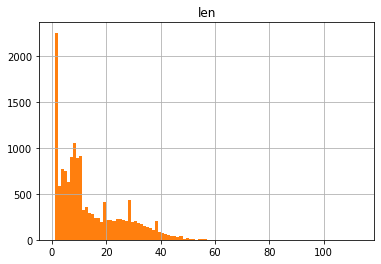

In [15]:
data.hist(bins=100)
data['len'].hist(bins=100)

In [16]:
# Keep a large percentage of reviews completely and chop of the remainig reviews off.

time_steps = int(np.quantile(data['len'],0.975))
time_steps

41

In [17]:
#Text Preprocessing
# Lower string
data['sentence'] = data['sentence'].str.lower()

## Prepration

### Tokenize

Data has already been tokenized. Do not tokenize further since that may lead to more tokens than labels in a sentence. 


### Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    data['sentence'].values.astype('U'),
    data['NER'],  # .values.astype('int32'),
    test_size=0.20,
    random_state=42
)

print(f"Number of samples: X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"Number of samples: X_test: {len(X_test)}, y_test: {len(y_test)}")

Number of samples: X_train: 11989, y_train: 11989
Number of samples: X_test: 2998, y_test: 2998


## (1C) Build Dictionaries

In [19]:
def encode(plain_text: str, word2index: Dict[str, int]) -> List[int]:
  """
  Encodes the plain text as per the word2index doctionary
  :param plain_text: The text to be encoded
  :param word2index: The Encoder dictionary
  """
  return [word2index[token] if token in word2index.keys() else word2index["<UNK>"] for token in plain_text.split(" ")]

def decode(encoded_text, index2word: Dict[int, str]):
  """
  Decodes the encoded text as per the index2word doctionary
  :param encoded_text: The encoded text that is to be decoded
  :param index2word: The decoder dictionary
  """
  return ' '.join([index2word.get(i, '?') for i in encoded_text])

In [20]:
def encode_decode_check(original: str, word2index: Dict[str, int], index2word: Dict[int, str]):
  """
  :param original: The text to be checked for encoding and decoding
  :param word2index: The Encoder dictionary
  :param index2word: The decoder dictionary
  """
  print("\n")
  print(f"Original: {original}")
  encoded = encode(original, word2index)
  print(f"Encoded: {encoded}")
  decoded = decode(encoded, index2word)
  print(f"Decoded: {decoded}")
  same = decoded == original
  print(f"Decoded = Original: {same}")

### (1C.1) Vocabulary

In [21]:
corpus = []
for _, row in enumerate(X_train):
  corpus = corpus + row.split(" ")

In [22]:
X_train[:2]

array(['wednesday , august 28th schedule', 'toronto 58 69 .457 15'],
      dtype='<U512')

In [23]:
print(corpus[:15])

['wednesday', ',', 'august', '28th', 'schedule', 'toronto', '58', '69', '.457', '15', '-docstart-', 'two', 'key', 'players', 'left']


In [24]:
# Get only words that have occured more than a certain threshold to remove noise, spelling mistakes and possible tokenization errors (if done).
fdist = nltk.FreqDist(corpus)
print(fdist.most_common()[:20])
vocab = [word for word, count in fdist.most_common() if count >= 1]
print(vocab[:20])

[('the', 6624), ('.', 5848), (',', 5812), ('of', 3062), ('in', 2876), ('to', 2721), ('a', 2529), (')', 2315), ('(', 2314), ('and', 2279), ('"', 1755), ('on', 1654), ('said', 1473), ("'s", 1248), ('for', 1171), ('1', 1125), ('-', 1021), ('at', 921), ('was', 870), ('2', 781)]
['the', '.', ',', 'of', 'in', 'to', 'a', ')', '(', 'and', '"', 'on', 'said', "'s", 'for', '1', '-', 'at', 'was', '2']


In [25]:
len(vocab)

18804

#### Encoding and Decoding Dictionary

In [26]:
word_index = {}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
for index, word in enumerate(vocab):
  word_index[word] = index+3

In [27]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
[(i, reverse_word_index.get(i)) for i in np.arange(10)]

[(0, '<PAD>'),
 (1, '<START>'),
 (2, '<UNK>'),
 (3, 'the'),
 (4, '.'),
 (5, ','),
 (6, 'of'),
 (7, 'in'),
 (8, 'to'),
 (9, 'a')]

In [28]:
vocabulary_size = len(word_index.keys())
vocabulary_size

18807

#### Check encoding and Decoding

**Observations:**

Train Reviews and test reviews have UNK tokens introduced for words not in the vocabulary, but apart from this, they match up.

In [29]:
random_train_data = X_train[np.random.choice(len(X_train), 5)]
random_train_data

for data_row in random_train_data:
  encode_decode_check(data_row, word2index=word_index, index2word=reverse_word_index)



Original: coughlan said the market had more downside than upside potential , but a fall was not likely to be of significant size .
Encoded: [5405, 15, 3, 131, 38, 110, 10841, 135, 7194, 1988, 5, 40, 9, 562, 21, 37, 844, 8, 41, 6, 1544, 3571, 4]
Decoded: coughlan said the market had more downside than upside potential , but a fall was not likely to be of significant size .
Decoded = Original: True


Original: nearly 100 students have been injured in the clashes in dhaka and bogra , police told reporters .
Encoded: [728, 333, 1767, 44, 55, 701, 7, 3, 2321, 7, 1260, 12, 3668, 5, 78, 95, 463, 4]
Decoded: nearly 100 students have been injured in the clashes in dhaka and bogra , police told reporters .
Decoded = Original: True


Original: the airliner refuelled at larnaca , cyprus and landed at london 's stansted airport in the early hours of tuesday .
Encoded: [3, 2887, 5423, 20, 2979, 5, 1296, 12, 1167, 20, 98, 16, 1056, 526, 7, 3, 303, 603, 6, 88, 4]
Decoded: the airliner refuelled at l

In [30]:
random_test_data = X_test[np.random.choice(len(X_test), 5)]
random_test_data

for data_row in random_test_data:
  encode_decode_check(data_row, word2index=word_index, index2word=reverse_word_index)



Original: advanced medical , through imed , is already one of the nation 's largest developers and manufacturers of intravenous infusion pumps and proprietary disposable products .
Encoded: [1430, 814, 5, 188, 3926, 5, 33, 535, 71, 6, 3, 1344, 16, 2048, 11280, 12, 4008, 6, 6441, 2441, 9562, 12, 6443, 9565, 1050, 4]
Decoded: advanced medical , through imed , is already one of the nation 's largest developers and manufacturers of intravenous infusion pumps and proprietary disposable products .
Decoded = Original: True


Original: gabriel ( 86th )
Encoded: [5594, 11, 3414, 10]
Decoded: gabriel ( 86th )
Decoded = Original: True


Original: 16,000 .
Encoded: [7521, 4]
Decoded: 16,000 .
Decoded = Original: True


Original: but nutricia shrugged off its ex-div tag to soar a further 4.10 guilders to 214.40 continuing its explosive rally sparked by the 51 percent jump in first half net profits last week , which set the market alight on friday , sending the shares up 18.40 at 210.00 by the clo

#### Encode Sequence

In [31]:
X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]

In [32]:
print(X_train[:2])
print(X_train_encoded[:2])

['wednesday , august 28th schedule' 'toronto 58 69 .457 15']
[[75, 5, 163, 3243, 944], [481, 900, 227, 3901, 152]]


In [33]:
print(X_test[:2])
print(X_test_encoded[:2])

['press digest - sri lankan newspapers - august 27 .'
 "the spla has fought khartoum 's government forces in the south since 1983 for greater autonomy or independence of the mainly christian and animist region from the moslem , arabised north ."]
[[382, 1218, 19, 419, 2324, 1604, 19, 163, 702, 4], [3, 3021, 36, 2768, 1545, 16, 77, 551, 7, 3, 118, 164, 8273, 17, 4873, 3947, 97, 788, 6, 3, 4746, 1978, 12, 2, 631, 30, 3, 936, 5, 2, 306, 4]]


### (1C.2) Labels 

In [34]:
labels = []
for _, row in enumerate(data['NER'].values):
  labels = labels + row.split(" ")

In [35]:
print(labels[:15])

['O', 'B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER', 'I-PER', 'B-LOC', 'O', 'O']


In [36]:
fdist = nltk.FreqDist(labels)
print(fdist.most_common())
label_vocab = [word for word, count in fdist.most_common()]
print(label_vocab)

[('O', 170524), ('B-LOC', 7140), ('B-PER', 6600), ('B-ORG', 6321), ('I-PER', 4528), ('I-ORG', 3704), ('B-MISC', 3438), ('I-LOC', 1157), ('I-MISC', 1155)]
['O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'B-MISC', 'I-LOC', 'I-MISC']


In [37]:
label_vocab_len = len(label_vocab)
label_vocab_len

9

#### Encoding and Decoding Dictionary

In [38]:
label_index = {}
for index, label in enumerate(label_vocab):
  label_index[label] = index

LABEL_PAD_VALUE = index+1
label_index['<PAD>'] = LABEL_PAD_VALUE
label_vocab_len = label_vocab_len + 1

In [39]:
reverse_label_index = dict([(value, key) for (key, value) in label_index.items()])
[(i, reverse_label_index.get(i)) for i in np.arange(label_vocab_len)]

[(0, 'O'),
 (1, 'B-LOC'),
 (2, 'B-PER'),
 (3, 'B-ORG'),
 (4, 'I-PER'),
 (5, 'I-ORG'),
 (6, 'B-MISC'),
 (7, 'I-LOC'),
 (8, 'I-MISC'),
 (9, '<PAD>')]

#### Check encoding and Decoding

In [40]:
random_train_labels = y_train.reset_index(drop=True)[np.random.choice(len(y_train), 5)]

for data_row in random_train_labels:
  encode_decode_check(data_row, word2index=label_index, index2word=reverse_label_index)



Original: O B-LOC I-LOC O O O O B-LOC O O O O O O O O O
Encoded: [0, 1, 7, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: O B-LOC I-LOC O O O O B-LOC O O O O O O O O O
Decoded = Original: True


Original: O O O O O O O O
Encoded: [0, 0, 0, 0, 0, 0, 0, 0]
Decoded: O O O O O O O O
Decoded = Original: True


Original: O O O O O O O B-LOC O O O
Encoded: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Decoded: O O O O O O O B-LOC O O O
Decoded = Original: True


Original: O O O O O O O O B-ORG O O O B-LOC I-LOC O O O O O B-LOC I-LOC O O O O O O O O B-LOC I-LOC O
Encoded: [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 7, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0]
Decoded: O O O O O O O O B-ORG O O O B-LOC I-LOC O O O O O B-LOC I-LOC O O O O O O O O B-LOC I-LOC O
Decoded = Original: True


Original: O O O O B-MISC
Encoded: [0, 0, 0, 0, 6]
Decoded: O O O O B-MISC
Decoded = Original: True


In [41]:
random_test_labels = y_test.reset_index(drop=True)[np.random.choice(len(y_test), 5)]

for data_row in random_test_labels:
  encode_decode_check(data_row, word2index=label_index, index2word=reverse_label_index)



Original: O O O O O O O O O O O O O O O B-PER O O
Encoded: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
Decoded: O O O O O O O O O O O O O O O B-PER O O
Decoded = Original: True


Original: O O O O O B-PER I-PER I-PER I-PER O O O O O O O O O O O B-LOC O O O O O O O O B-LOC O O O O O
Encoded: [0, 0, 0, 0, 0, 2, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Decoded: O O O O O B-PER I-PER I-PER I-PER O O O O O O O O O O O B-LOC O O O O O O O O B-LOC O O O O O
Decoded = Original: True


Original: O B-PER I-PER
Encoded: [0, 2, 4]
Decoded: O B-PER I-PER
Decoded = Original: True


Original: B-ORG I-ORG O O O O O O O
Encoded: [3, 5, 0, 0, 0, 0, 0, 0, 0]
Decoded: B-ORG I-ORG O O O O O O O
Decoded = Original: True


Original: B-PER O O O O
Encoded: [2, 0, 0, 0, 0]
Decoded: B-PER O O O O
Decoded = Original: True


#### Encode Labels

In [42]:
y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

In [43]:
print(y_train[:2])
print(y_train_encoded[:2])

11112        O O O O O
820      B-ORG O O O O
Name: NER, dtype: object
[[0, 0, 0, 0, 0], [3, 0, 0, 0, 0]]


In [44]:
print(y_test[:2])
print(y_test_encoded[:2])

10005                        O O O B-MISC I-MISC O O O O O
9470     O B-ORG O O B-LOC O O O O O O O O O O O O O O ...
Name: NER, dtype: object
[[0, 0, 0, 6, 8, 0, 0, 0, 0, 0], [0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 1, 7, 0]]


## Check Distribution of labels

In [45]:
#https://www.geeksforgeeks.org/python-count-the-sublists-containing-given-element-in-a-list/
def countList(lst, x): 
    return sum(x in item for item in lst) 

In [46]:
def label_distribution(labels):
    total = 0
    label_count = np.zeros((0, 2))
    for key in reverse_label_index.keys():
        count = countList(labels, key)
        label_count = np.vstack((label_count,[key, count]))
        
    label_count = np.append(label_count, (label_count[:,1]/sum(label_count[:,1]) * 100).reshape(-1,1), axis=1)
    label_count = pd.DataFrame(label_count)
    label_count.columns = ['label', 'count', 'percentage']
    label_count['label'] = label_count['label'].astype(int)
    return label_count

In [47]:
train_label_dist = label_distribution(y_train_encoded)
train_label_dist['dataset'] = 'Train'
# train_label_dist

test_label_dist = label_distribution(y_test_encoded)
test_label_dist['dataset'] = 'Test'
# test_label_dist

label_dist = pd.concat([train_label_dist, test_label_dist])
# label_dist

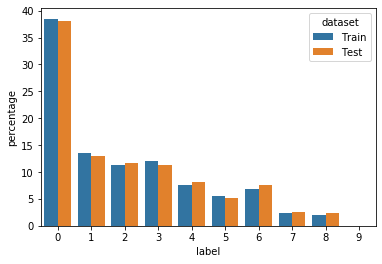

In [48]:
ax = sns.barplot(x="label", y="percentage", hue="dataset", data=label_dist)

**Observations:**

* Roughly the same distribution across the train and test set

## (1D) Zero padding

In [49]:
X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)

In [50]:
# Here we need to pass the value of the <PAD> which is 9 and not the default value of 0
y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)
y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)

In [51]:
print(X_train[0:4])
print(X_train_encoded[0:4])

['wednesday , august 28th schedule' 'toronto 58 69 .457 15' '-docstart-'
 'two key players left a brazilian championship match early on sunday because they had to catch a plane to russia to play with the national team .']
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   75    5  163 3243  944]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  481  900  227 3901  152]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   23]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    52  984  454  338    9 1103  355  134  303   14  112  173   51   3

In [52]:
print(y_train[0:4])
print(y_train_encoded[0:4])

11112                                            O O O O O
820                                          B-ORG O O O O
1643                                                     O
7210     O O O O O B-MISC O O O O O O O O O O O O O B-L...
Name: NER, dtype: object
[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  3 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 9 9 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0]]


# (2) Models

In [53]:
def plot_metrics(history: tf.keras.callbacks.History, metrics: List[str] = ['loss'], figsize: Tuple[int, int] = (10,4), title: str = "Train/Test Curves", titlefontsize:int = 14):
  """
  This functin will plot the metrics for the model
  :param history: The history object obtained from the fit function.
  :type history: tf.python.keras.callbacks.History
  :param metrics: What metrics to plot for the model (Default = ['loss'])
  :type metrics: List[str]
  :param figsize: Figure size to be used for plotting (Default = (10,4))
  :type figsize: Tuple(int,int)
  """
  num_plots = len(metrics)
  fig, axes = plt.subplots(int(num_plots/2), 2, figsize=figsize)

  for num, metric in enumerate(metrics):
    # summarize history for metric
    if num <= 2:
      axes[num%2].plot(history.history[metric])
      axes[num%2].plot(history.history['val_' + metric])
      axes[num%2].set_title('Model ' + metric)
      axes[num%2].set(xlabel='Epoch', ylabel=metric)
      axes[num%2].legend(['train', 'val'], loc='best')    
    else:
      axes[floor(num/2), num%2].plot(history.history[metric])
      axes[floor(num/2), num%2].plot(history.history['val_' + metric])
      axes[floor(num/2), num%2].set_title('Model ' + metric)
      axes[floor(num/2), num%2].set(xlabel='Epoch', ylabel=metric)
      axes[floor(num/2), num%2].legend(['train', 'val'], loc='best')

  plt.suptitle(title, fontsize=titlefontsize, y=1.02)    
  plt.tight_layout()
  _ = plt.show

In [54]:
# If validation error does not improve for 10 epochs, then terminate the training
es = EarlyStopping(min_delta=0,patience=2)  # Reduced from 10 to lower value since training takes a long time for this model

In [55]:
# add a checkpoint to save the lowest validation loss
filepath = '.'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', save_frequency=1)

In [56]:
def create_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, type: str = 'lstm', direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Sequence Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param type Type of sequence model (Options: 'simple_rnn', 'lstm' or 'gru' (Default: 'lstm')
  :type type str
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = Sequential()
  model.add(Embedding(vocabulary_size, embedding_size, input_length=time_steps))
  if type.lower() == 'simple_rnn':
    if direction.lower() == 'uni':
      model.add(RNN(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(RNN(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  elif type.lower() == 'lstm':
    if direction.lower() == 'uni':
      model.add(LSTM(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(LSTM(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  elif type.lower() == 'gru':
    if direction.lower() == 'uni':
      model.add(GRU(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
    elif direction.lower() == 'bi':
      model.add(Bidirectional(GRU(num_neuron, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout)))
    else:
      sys.exit("You have not passed the right argument for 'direction'. Allowed values are 'uni' for unidirectinal model, or 'bi' for bidirectional model.")
  else:
    sys.exit("You have not passed the right argument for 'type'. Allowed values are 'simple_rnn', 'lstm' or 'gru'.")
  model.add(TimeDistributed(Dense(num_labels, activation='softmax')))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def create_simple_rnn_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a Simple RNN Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'simple_rnn', direction, num_neuron, dropout, recurrent_dropout)
  return model

def create_lstm_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a LSTM Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'lstm', direction, num_neuron, dropout, recurrent_dropout)
  return model

def create_gru_model_multiple_outputs(vocabulary_size: int, time_steps: int, embedding_size: int, num_labels: int, direction: str = 'uni', num_neuron: int=100, dropout: float=0, recurrent_dropout: float=0) -> tf.keras.layers.Layer:
  """
  Creates a GRU Model with the passed parameters
  :param vocabulary_size Size of the Vocabulary
  :type vocabulary_size int
  :param time_steps Number of steps in the sequence (e.g. length of sentence)
  :type time_steps int
  :param embedding_size Size of the Embedding 
  :type embedding_size int
  :param num_neuron Number of neurons to be passed to the "cell"
  :type num_neuron int
  :param dropout Amount of dropout to use between the memory layer and the fully connected layer
  :type dropout float
  :param recurrent_dropout Amount of recurrent dropout to use
  :type recurrent_dropout float
  :rtype tf.keras.layers.Layer
  """
  model = create_model_multiple_outputs(vocabulary_size, time_steps, embedding_size, num_labels, 'gru', direction, num_neuron, dropout, recurrent_dropout)
  return model

In [59]:
num_combinations = 3 # Number of hyperparameter combinations
EPOCHS=10  # 50
BATCH_SIZE=32

## (2) Unidirectional LSTM 





---------------------------------------------------------------------------
Training model for hyperparameter combination 1:
Quantile: 0.8749080237694725 --> Time Steps: 30
Embedding Size: 24, Num Neurons: 47, Dropout: 0.3118764001091077, Rec. Dropout: 0.5193700315892974
---------------------------------------------------------------------------


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 24)            451368    
_________________________________________________________________
lstm (LSTM)                  (None, 30, 47)            13536     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 10)            480       
Total params: 465,384
Trainable params: 465,384
Non-trainable params: 0
_________________________________________________________________
None
Train on 11989 sample

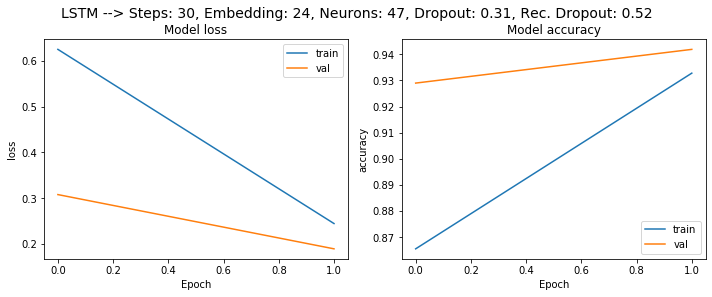

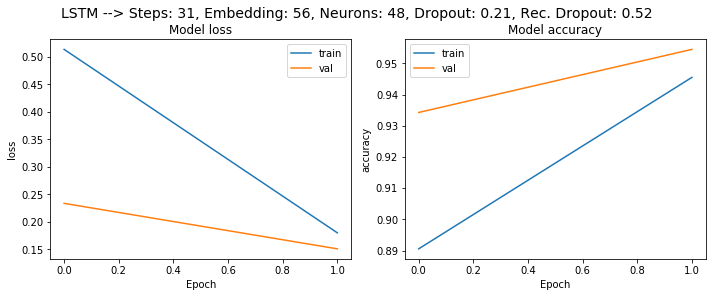

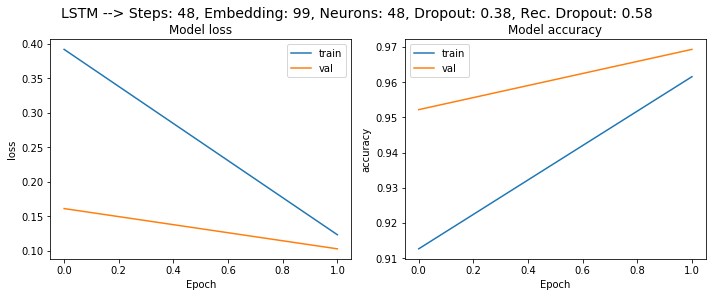

In [60]:
# Random Grid Search 
np.random.seed(42)
tf.random.set_seed(42)

direction = 'uni'

histories = []
models = []
embedding_sizes = []
num_neurons = []
dropouts = []
recurrent_dropouts = []
num_time_steps = []

X_trains_encoded = []
X_tests_encoded = []
y_trains_encoded = []
y_tests_encoded = []

for hyper_index in np.arange(num_combinations):
 
  # Random Sample Hyperparameter Space
  quantile = np.random.uniform(0.8, 1.00) 
  embeding_size = np.random.randint(10, 100)
  num_neuron = np.random.randint(5, 50)
  dropout = np.random.uniform(0, 0.4)
  recurrent_dropout = np.random.uniform(0.4, 0.6)

  time_steps = int(np.quantile(data['len'], quantile))

  # Encoding of X and y
  X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
  X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]
  y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
  y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

  # Padding of X and y
  X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
  X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)
  y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)
  y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)

  print("\n\n\n")
  print("-"*75)
  print(f"Training model for hyperparameter combination {hyper_index+1}:")
  print(f"Quantile: {quantile} --> Time Steps: {time_steps}")
  print(f"Embedding Size: {embeding_size}, Num Neurons: {num_neuron}, Dropout: {dropout}, Rec. Dropout: {recurrent_dropout}")
  print("-"*75)
  print("\n")

  # Build Model and Train
  model = create_lstm_model_multiple_outputs(vocabulary_size=vocabulary_size, embedding_size=embeding_size, num_labels=label_vocab_len, direction = direction, time_steps=time_steps, num_neuron=num_neuron, dropout=dropout, recurrent_dropout=recurrent_dropout)
  print(model.summary())
  history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_test_encoded, y_test_encoded), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es]) #, checkpoint])  # checkpoint causes issues with Bidirectional LSTM
  plot_metrics(history,
               metrics=['loss', 'accuracy'],
               title = f"LSTM --> Steps: {time_steps}, Embedding: {embeding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")

  # Housekeeping
  histories.append(history)
  models.append(model)
  embedding_sizes.append(embeding_size)
  num_neurons.append(num_neuron)
  dropouts.append(dropout)
  recurrent_dropouts.append(recurrent_dropout)
  num_time_steps.append(time_steps)

  X_trains_encoded.append(X_train_encoded)
  X_tests_encoded.append(X_test_encoded)
  y_trains_encoded.append(y_train_encoded)
  y_tests_encoded.append(y_test_encoded)

In [61]:
best_train_accuracies = [max(history.history['accuracy']) for history in histories]
best_test_accuracies = [max(history.history['val_accuracy']) for history in histories]
print(f"Train Accuracies: {best_train_accuracies}")
print(f"Test Accuracies: {best_test_accuracies}")

Train Accuracies: [0.9327773, 0.94552267, 0.96156025]
Test Accuracies: [0.94187236, 0.95449656, 0.96931285]


In [62]:
lstm_results_uni = pd.DataFrame({
    'time_steps': num_time_steps,
    'embedding_size':embedding_sizes,
    'num_neuron': num_neurons,
    'dropout': dropouts,
    'recurrent_dropout': recurrent_dropouts,
    'best_train_acc': best_train_accuracies,
    'best_test_acc': best_test_accuracies
  })
lstm_results_uni

,time_steps,embedding_size,num_neuron,dropout,recurrent_dropout,best_train_acc,best_test_acc
0,30,24,47,0.311876,0.519370,0.932777,0.941872
1,31,56,48,0.205694,0.518483,0.945523,0.954497
2,48,99,48,0.375800,0.578965,0.961560,0.969313


In [63]:
best_lstm_uni_acc = lstm_results_uni.sort_values("best_test_acc", ascending=False).iloc[0]["best_test_acc"]
print(f"Best Unidirectional LSTM Test Accuracy: {best_lstm_uni_acc}")

Best Unidirectional LSTM Test Accuracy: 0.969312846660614


In [64]:
max_idx_uni = lstm_results_uni['best_test_acc'].idxmax()
print(f"Max Test Accuracy for Unidirectional LSTM: {max_idx_uni}")

Max Test Accuracy for Unidirectional LSTM: 2


In [65]:
predictions_prob_uni = models[max_idx_uni].predict(X_tests_encoded[max_idx_uni])
predictions_uni = np.argmax(predictions_prob_uni, axis=-1)
predictions_uni

array([[9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 9, 9, 0],
       [9, 9, 9, ..., 0, 0, 0]], dtype=int64)

In [66]:
actual_uni = y_tests_encoded[max_idx_uni]
actual_uni

array([[9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 1, 7, 0],
       [9, 9, 9, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 9, 9, 0],
       [9, 9, 9, ..., 0, 0, 0]])

In [67]:
# Quick check
print(predictions_uni[0:5])
print(actual_uni[0:5])

[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 0 0 0 1 4 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 2 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 1 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  3 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 9 9 9 3 4 0 0 0 0 0]]
[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 0 0 0 6 8 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 3 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 6 0 0 0 0 0 6 0 1 7 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 3 5 5 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  2 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
  9 9 9 9 9 2 4 

In [68]:
### Flatten the results
actual_uni_flat =  [actual for sent in actual_uni for actual in sent]
pred_uni_flat =  [pred for sent in predictions_uni for pred in sent]

In [69]:
print(actual_uni_flat[:150])
print(pred_uni_flat[:150])

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 1, 7, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]


### Metrics 

#### (2A.1) Classwise Precision and Recall

In [70]:
print(classification_report(actual_uni_flat, pred_uni_flat, target_names=list(label_index.keys()) ))

precision    recall  f1-score   support

           O       0.95      1.00      0.97     34785
       B-LOC       0.44      0.77      0.56      1411
       B-PER       0.72      0.34      0.46      1382
       B-ORG       0.43      0.34      0.38      1215
       I-PER       0.58      0.69      0.63       959
       I-ORG       0.33      0.00      0.01       716
      B-MISC       0.88      0.01      0.02       706
       I-LOC       0.00      0.00      0.00       236
      I-MISC       0.00      0.00      0.00       263
       <PAD>       1.00      1.00      1.00    102231

    accuracy                           0.97    143904
   macro avg       0.53      0.42      0.40    143904
weighted avg       0.96      0.97      0.96    143904



#### (2A.2) Classwise Accuracy

In [71]:
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
cm = confusion_matrix(actual_uni_flat, pred_uni_flat) #Get the confusion matrix
cm

array([[ 34612,     48,     15,     66,     43,      0,      0,      0,
             0,      1],
       [   149,   1092,     25,    139,      6,      0,      0,      0,
             0,      0],
       [   308,    302,    468,    278,     19,      0,      0,      0,
             0,      7],
       [   287,    403,     99,    417,      7,      0,      1,      0,
             0,      1],
       [   273,      6,     14,      1,    658,      0,      0,      0,
             0,      7],
       [   381,     95,      9,      2,    225,      3,      0,      0,
             0,      1],
       [   136,    464,     18,     69,     12,      0,      7,      0,
             0,      0],
       [    72,     63,      5,      0,     96,      0,      0,      0,
             0,      0],
       [   159,     19,      1,      3,     75,      6,      0,      0,
             0,      0],
       [     0,      0,      0,      0,      0,      0,      0,      0,
             0, 102231]], dtype=int64)

In [72]:
accuracy = cm.diagonal()/cm.sum(axis=1) #This gives the accuracy of each class
accuracy_df = pd.DataFrame(accuracy, index = list(label_index.keys()))
accuracy_df

,0
O,0.995027
B-LOC,0.773919
B-PER,0.338640
B-ORG,0.343210
I-PER,0.686131
I-ORG,0.004190
B-MISC,0.009915
I-LOC,0.000000
I-MISC,0.000000
<PAD>,1.000000


#### (2B) Accuracy without 'O' tag

In [73]:
# Method 1: Using Masking approach
mask = [True if item != label_index.get('O') else False for item in actual_uni_flat] # True if label is not = 'O'
true = [True if actual == prediction else False for actual, prediction in zip(actual_uni_flat, pred_uni_flat)]
masked_true = [true_val * mask_val for true_val, mask_val in zip(true, mask)]
accuracy_without_tag = sum(masked_true)/sum(mask)
print(sum(masked_true))
print(sum(mask))
print(f"Accuracy without 'O' tag: {round(accuracy_without_tag, 3)}")

104876
109119
Accuracy without 'O' tag: 0.961


In [74]:
# Method 2: Using Confusion Matrix Approach
print(sum(cm.diagonal()[1:])) # Exclusing the entry for the 'O' tag which is index 0 
print(np.sum(cm[1:])) # Exclusing the entries for the 'O' tag which is row 0
accuracy_without_O = sum(cm.diagonal()[1:])/np.sum(cm[1:])
print(f"Accuracy without 'O' tag: {round(accuracy_without_O,3)}")

104876
109119
Accuracy without 'O' tag: 0.961


## (3) Bidirectional LSTM 





---------------------------------------------------------------------------
Training model for hyperparameter combination 1:
Quantile: 0.8749080237694725 --> Time Steps: 30
Embedding Size: 24, Num Neurons: 47, Dropout: 0.3118764001091077, Rec. Dropout: 0.5193700315892974
---------------------------------------------------------------------------


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 24)            451368    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 94)            27072     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 10)            950       
Total params: 479,390
Trainable params: 479,390
Non-trainable params: 0
_________________________________________________________________
None
Train on 11989 samp

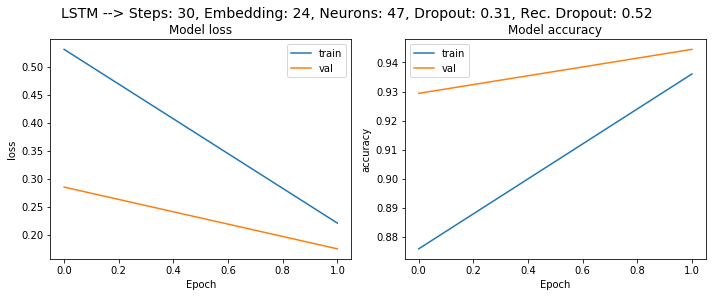

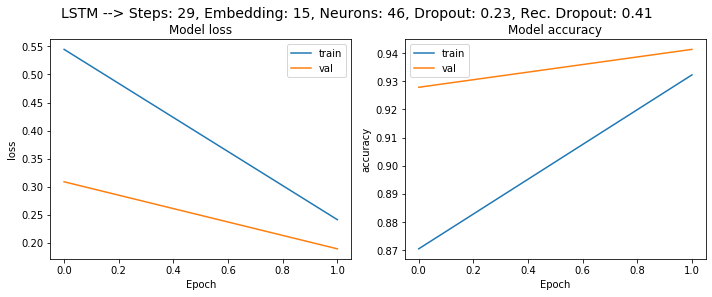

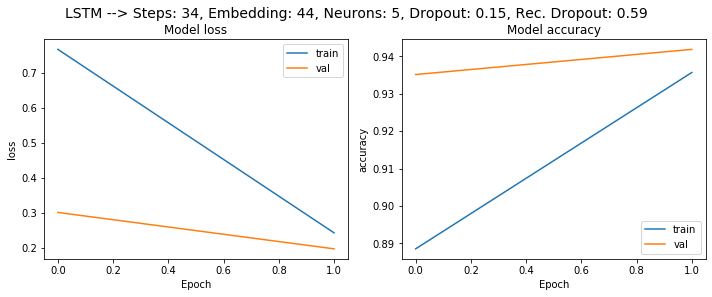

In [75]:
# Random Grid Search 
np.random.seed(42)
tf.random.set_seed(42)

direction = 'bi'

histories = []
models = []
embedding_sizes = []
num_neurons = []
dropouts = []
recurrent_dropouts = []
num_time_steps = []

X_trains_encoded = []
X_tests_encoded = []
y_trains_encoded = []
y_tests_encoded = []

for hyper_index in np.arange(num_combinations):
 
  # Random Sample Hyperparameter Space
  quantile = np.random.uniform(0.8, 1.00) 
  embeding_size = np.random.randint(10, 100)
  num_neuron = np.random.randint(5, 50)
  dropout = np.random.uniform(0, 0.4)
  recurrent_dropout = np.random.uniform(0.4, 0.6)

  time_steps = int(np.quantile(data['len'], quantile))

  # Encoding of X and y
  X_train_encoded = [encode(data_row, word2index=word_index) for data_row in X_train]
  X_test_encoded = [encode(data_row, word2index=word_index) for data_row in X_test]
  y_train_encoded = [encode(label_row, word2index=label_index) for label_row in y_train]
  y_test_encoded = [encode(label_row, word2index=label_index) for label_row in y_test]

  # Padding of X and y
  X_train_encoded = sequence.pad_sequences(X_train_encoded, maxlen=time_steps)
  X_test_encoded = sequence.pad_sequences(X_test_encoded, maxlen=time_steps)
  y_train_encoded = sequence.pad_sequences(y_train_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)
  y_test_encoded = sequence.pad_sequences(y_test_encoded, maxlen=time_steps, value = LABEL_PAD_VALUE)

  print("\n\n\n")
  print("-"*75)
  print(f"Training model for hyperparameter combination {hyper_index+1}:")
  print(f"Quantile: {quantile} --> Time Steps: {time_steps}")
  print(f"Embedding Size: {embeding_size}, Num Neurons: {num_neuron}, Dropout: {dropout}, Rec. Dropout: {recurrent_dropout}")
  print("-"*75)
  print("\n")

  # Build Model and Train
  model = create_lstm_model_multiple_outputs(vocabulary_size=vocabulary_size, embedding_size=embeding_size, num_labels=label_vocab_len, direction = direction, time_steps=time_steps, num_neuron=num_neuron, dropout=dropout, recurrent_dropout=recurrent_dropout)
  print(model.summary())
  history = model.fit(X_train_encoded, y_train_encoded, validation_data=(X_test_encoded, y_test_encoded), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es]) #, checkpoint])  # checkpoint causes issues with Bidirectional LSTM
  plot_metrics(history,
               metrics=['loss', 'accuracy'],
               title = f"LSTM --> Steps: {time_steps}, Embedding: {embeding_size}, Neurons: {num_neuron}, Dropout: {round(dropout,2)}, Rec. Dropout: {round(recurrent_dropout,2)}")

  # Housekeeping
  histories.append(history)
  models.append(model)
  embedding_sizes.append(embeding_size)
  num_neurons.append(num_neuron)
  dropouts.append(dropout)
  recurrent_dropouts.append(recurrent_dropout)
  num_time_steps.append(time_steps)

  X_trains_encoded.append(X_train_encoded)
  X_tests_encoded.append(X_test_encoded)
  y_trains_encoded.append(y_train_encoded)
  y_tests_encoded.append(y_test_encoded)

In [76]:
best_train_accuracies = [max(history.history['accuracy']) for history in histories]
best_test_accuracies = [max(history.history['val_accuracy']) for history in histories]
print(f"Train Accuracies: {best_train_accuracies}")
print(f"Test Accuracies: {best_test_accuracies}")

Train Accuracies: [0.93604136, 0.93228275, 0.9356788]
Test Accuracies: [0.94449633, 0.9413402, 0.9418632]


In [77]:
lstm_results_bi = pd.DataFrame({
    'time_steps': num_time_steps,
    'embedding_size':embedding_sizes,
    'num_neuron': num_neurons,
    'dropout': dropouts,
    'recurrent_dropout': recurrent_dropouts,
    'best_train_acc': best_train_accuracies,
    'best_test_acc': best_test_accuracies
  })
lstm_results_bi

,time_steps,embedding_size,num_neuron,dropout,recurrent_dropout,best_train_acc,best_test_acc
0,30,24,47,0.311876,0.519370,0.936041,0.944496
1,29,15,46,0.227080,0.406263,0.932283,0.941340
2,34,44,5,0.153171,0.594342,0.935679,0.941863


In [78]:
best_lstm_bi_acc = lstm_results_bi.sort_values("best_test_acc", ascending=False).iloc[0]["best_test_acc"]
print(f"Best Bidirectional LSTM Test Accuracy: {best_lstm_bi_acc}")

Best Bidirectional LSTM Test Accuracy: 0.9444963335990906


In [79]:
max_idx_bi = lstm_results_bi['best_test_acc'].idxmax()
print(f"Max Test Accuracy for Bidirectional LSTM: {max_idx_bi}")

Max Test Accuracy for Bidirectional LSTM: 0


In [80]:
predictions_prob_bi = models[max_idx_bi].predict(X_tests_encoded[max_idx_bi])
predictions_bi = np.argmax(predictions_prob_bi, axis=-1)
predictions_bi

array([[9, 9, 9, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 9, 9, ..., 0, 0, 0],
       [9, 9, 9, ..., 9, 9, 0],
       [9, 9, 9, ..., 0, 0, 0]], dtype=int64)

In [81]:
actual_bi = y_tests_encoded[max_idx_bi]

In [82]:
# Quick check
print(predictions_bi[0:5])
print(actual_bi[0:5])

[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 3 0 0 0 0 0]]
[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 6 8 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 6 0 1 7 0]
 [0 0 0 0 0 0 0 0 3 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 0 0 0 0 0 0 0 0 0 0 0]
 [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 2 4 0 0 0 0 0]]


In [83]:
### Flatten the results
actual_bi_flat =  [actual for sent in actual_bi for actual in sent]
pred_bi_flat =  [pred for sent in predictions_bi for pred in sent]

In [84]:
print(actual_bi_flat[:150])
print(pred_bi_flat[:150])

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 6, 8, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 4, 0, 0, 0, 0, 0]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 3, 3, 0, 0, 0, 0, 0]


### Metrics 

#### (2A.1) Classwise Precision and Recall

In [85]:
print(classification_report(actual_bi_flat, pred_bi_flat, target_names=list(label_index.keys()) ))

precision    recall  f1-score   support

           O       0.93      1.00      0.96     32531
       B-LOC       0.35      0.62      0.45      1320
       B-PER       0.38      0.01      0.02      1231
       B-ORG       0.35      0.33      0.34      1139
       I-PER       0.66      0.20      0.31       883
       I-ORG       0.00      0.00      0.00       662
      B-MISC       0.25      0.02      0.04       652
       I-LOC       0.00      0.00      0.00       207
      I-MISC       0.00      0.00      0.00       254
       <PAD>       1.00      1.00      1.00     51061

    accuracy                           0.94     89940
   macro avg       0.39      0.32      0.31     89940
weighted avg       0.93      0.94      0.93     89940



#### (2A.2) Classwise Accuracy

In [86]:
# https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
cm = confusion_matrix(actual_bi_flat, pred_bi_flat) #Get the confusion matrix
cm

array([[32483,    37,     1,     9,     0,     0,     1,     0,     0,
            0],
       [  224,   819,     0,   202,     0,     0,     9,     0,     0,
           66],
       [  507,   493,    11,   189,     1,     0,    16,     0,     0,
           14],
       [  394,   346,     1,   380,     0,     0,     4,     0,     0,
           14],
       [  518,    74,    12,    88,   181,     0,     3,     0,     0,
            7],
       [  434,    83,     1,   106,    33,     0,     4,     0,     0,
            1],
       [  181,   381,     1,    50,     1,     0,    13,     0,     0,
           25],
       [   71,    64,     1,    33,    36,     0,     1,     0,     0,
            1],
       [  163,    46,     1,    18,    21,     0,     2,     0,     0,
            3],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        51061]], dtype=int64)

In [87]:
accuracy = cm.diagonal()/cm.sum(axis=1) #This gives the accuracy of each class
accuracy_df = pd.DataFrame(accuracy, index = list(label_index.keys()))
accuracy_df

,0
O,0.998524
B-LOC,0.620455
B-PER,0.008936
B-ORG,0.333626
I-PER,0.204983
I-ORG,0.000000
B-MISC,0.019939
I-LOC,0.000000
I-MISC,0.000000
<PAD>,1.000000


#### (2B) Accuracy without 'O' tag

In [88]:
# Method 1: Using Masking approach
mask = [True if item != label_index.get('O') else False for item in actual_bi_flat] # True if label is not = 'O'
true = [True if actual == prediction else False for actual, prediction in zip(actual_bi_flat, pred_bi_flat)]
masked_true = [true_val * mask_val for true_val, mask_val in zip(true, mask)]
accuracy_without_tag = sum(masked_true)/sum(mask)
print(sum(masked_true))
print(sum(mask))
print(f"Accuracy without 'O' tag: {round(accuracy_without_tag,3)}")

52465
57409
Accuracy without 'O' tag: 0.914


In [89]:
# Method 2: Using Confusion Matrix Approach
print(sum(cm.diagonal()[1:])) # Exclusing the entry for the 'O' tag which is index 0 
print(np.sum(cm[1:])) # Exclusing the entries for the 'O' tag which is row 0
accuracy_without_O = sum(cm.diagonal()[1:])/np.sum(cm[1:])
print(f"Accuracy without 'O' tag: {round(accuracy_without_O,3)}")

52465
57409
Accuracy without 'O' tag: 0.914


# Final Thoughts

While the exercise asked to find the accuracy without the 'O' tag, a true test would have been to also exclude the '<PAD>' tags (Since 'O' and '<PAD>' tags dominate the data). Just excluding the 'O' tag did reduce the accuracy a little, but excluding the '<PAD>' in addition to the 'O' tag would have brought out the real issues that the networks are not able to learn the other tags well.